In [3]:
#### CALCULATION OF EWMA, GENERATION OF SIGNALS, EXECUTING OF STRATEGY + SIMPLE BUY AND HOLD FOR REAL WORLD PAST DATA ####

__This script demonstrates the backtest model used for the thesis.__

In the following, all necessary steps to setup the backtesting model are shown. The data preparation that is necessary to download the closing prices from FactSet and calculate the 1x, 2x, and 3x daily returns is skipped. 

First, we import all necessary libraries

In [14]:
import numpy as np
import pandas as pd
import matplot as pyplot 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import NullLocator
from tabulate import tabulate
import os as os
%matplotlib inline

The xlsx file contains a closing price and all needed daily returns for each date.

In [5]:
DF_Results = pd.read_excel(r'C:\Users\Juli\OneDrive - reutlingen-university.de\Thesis_Folder\Source_Excel\NTR_DF_Results50.xlsx')
DF_Results.head()


,Date,Closing Price,Daily Returns,2x Lev Daily Returns,3x Lev Daily Returns
0,1987-01-01,804.28,0.000000,0.000000,0.000000
1,1987-01-02,796.21,-0.010034,-0.020068,-0.030101
2,1987-01-05,802.06,0.007347,0.014695,0.022042
3,1987-01-06,805.62,0.004439,0.008877,0.013316
4,1987-01-07,802.80,-0.003500,-0.007001,-0.010501


The following cell contains the calculation of the EWMA. In addition, buy and sell signals are generated for each day.

In [6]:
#### EWMA CALCULATION AND SIGNAL GENERATION #### 

def EMA(data, period):
    weights = np.exp(np.linspace(-1, 0, period))
    weights /= weights.sum()
    ema = np.convolve(data, weights, mode='full')[:len(data)]
    ema[:period] = ema[period]
    return ema

# set the number of days for EMA calculation
period = 200

# set the number of days for the average calculation
average_period = 1

# calculate EMA
DF_Results['EMA'] = EMA(DF_Results['Closing Price'], period)

# initialize the signals as 0
DF_Results['Signals_EMA'] = 0

# loop over the dataframe to generate signals
for i in range(period + average_period, len(DF_Results)):
    current_price = DF_Results.loc[i, 'Closing Price']
    current_ema = DF_Results.loc[i, 'EMA']
  
    # generate buy signal
    if current_price > current_ema:
        DF_Results.loc[i, 'Signals_EMA'] = 2
    
    # generate sell signal
    elif current_price < current_ema:
        DF_Results.loc[i, 'Signals_EMA'] = 1

    else:
        DF_Results.loc[i, 'Signals_EMA'] = 0


DF_Results.head()


,Date,Closing Price,Daily Returns,2x Lev Daily Returns,3x Lev Daily Returns,EMA,Signals_EMA
0,1987-01-01,804.28,0.000000,0.000000,0.000000,792.473673,0
1,1987-01-02,796.21,-0.010034,-0.020068,-0.030101,792.473673,0
2,1987-01-05,802.06,0.007347,0.014695,0.022042,792.473673,0
3,1987-01-06,805.62,0.004439,0.008877,0.013316,792.473673,0
4,1987-01-07,802.80,-0.003500,-0.007001,-0.010501,792.473673,0


Let's plot the calculated EWMA200:

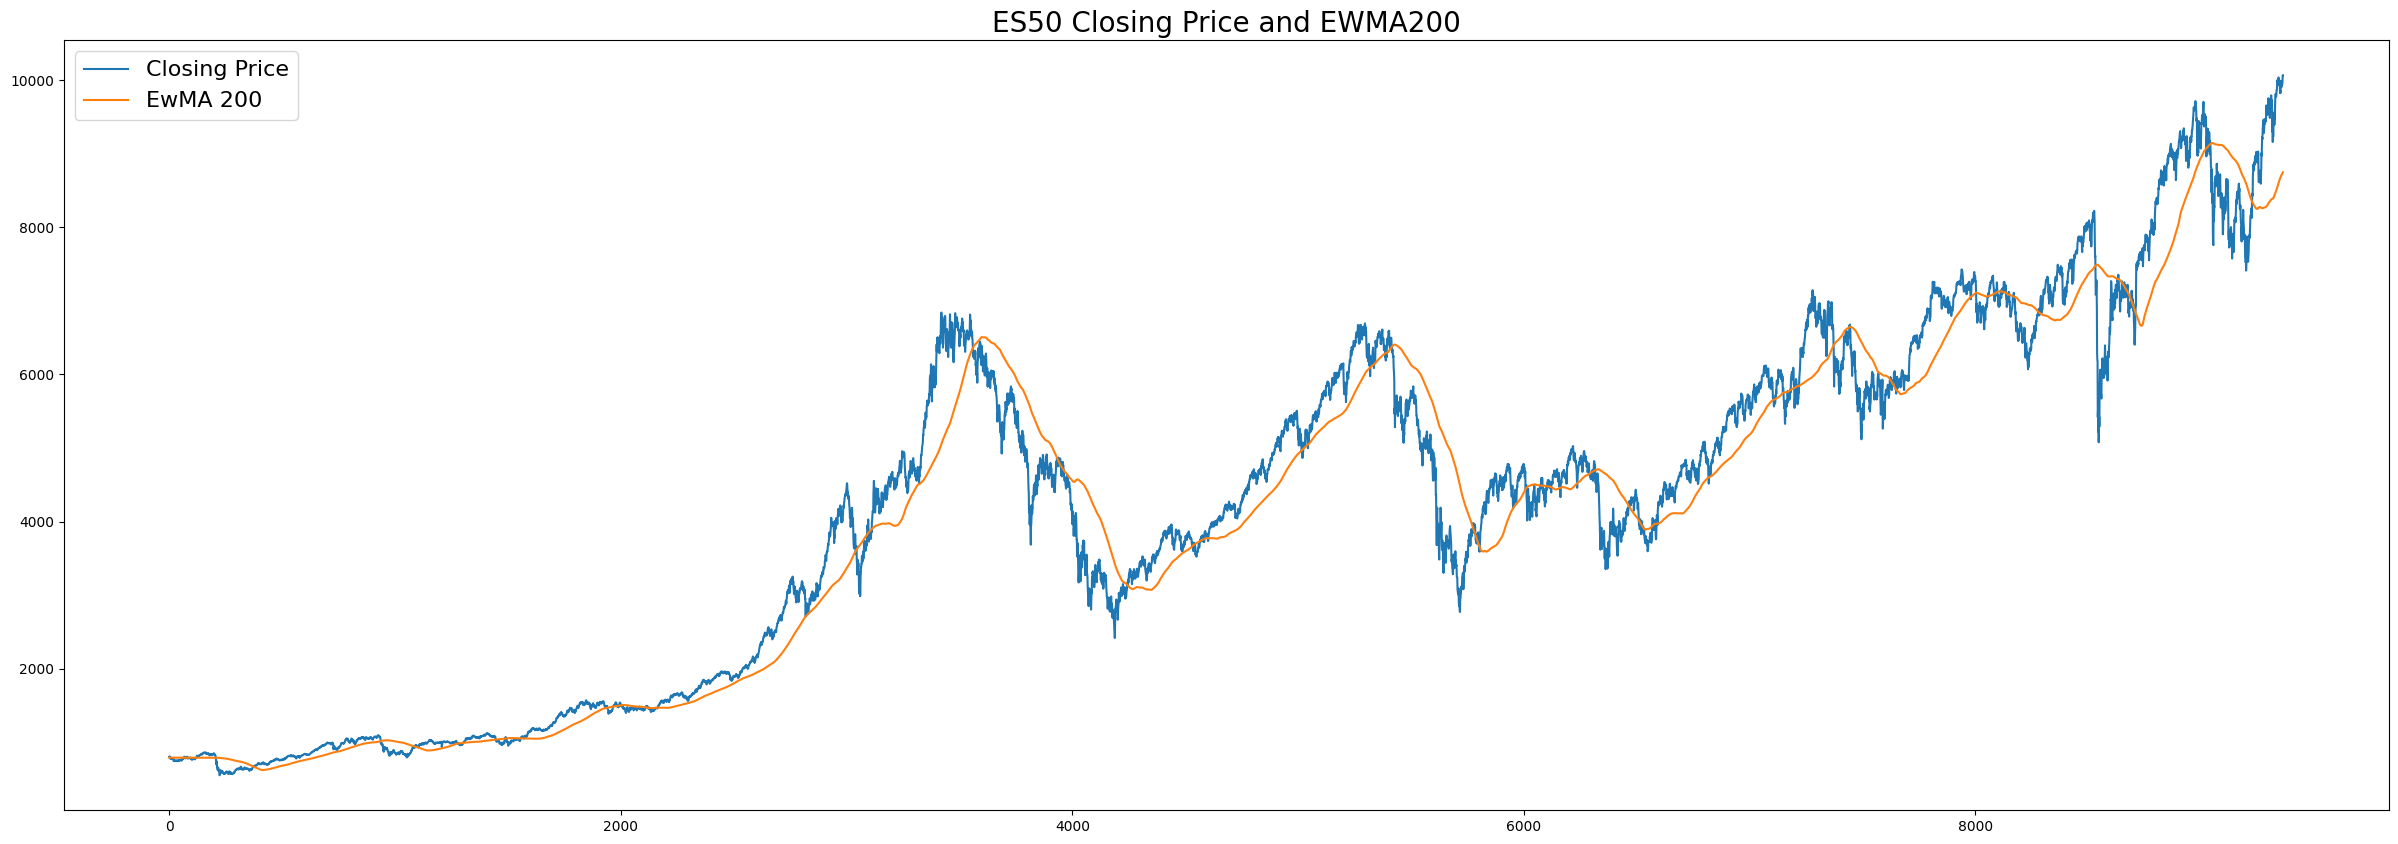

In [7]:
plt.figure(figsize=(30,10))
true, = plt.plot(DF_Results['Closing Price'])
preds, = plt.plot(DF_Results['EMA'])
plt.title('ES50 Closing Price and EWMA200', fontsize=20)
plt.legend(['Closing Price', 'EwMA 200'], fontsize=16)

In the next cell, I define the trading conditions.

In [9]:
### Define initial parameters for all following cells representing different portfolios ###

                                
transaction_cost = 10            ## Transaction cost that is applied on every buy and every sell transaction 
tax_rate =  0.25                    ## Tax rate that is applied on the capital gains from every sell
spread = 0.0032                         ## Spread that is multiplied with the sum to be invested (cash_amount_x1) and then deducted from the cash_amount_x1 to get the new investment_amount_x1
TER_pa = 0.0075                             ## Total Expense Ratio per annum


The next three cells calculate the portfolio value for each day investing in a 1x ETF, 2x LETF and lastly 3x LETF.

In [10]:
## Für 1x unleveraged strategy ###

portfolio_value = np.zeros(len(DF_Results))
cash_amount_1x= 10000
portfolio_value[0] = cash_amount_1x  # set the first value to 0
invested_amounts_1x = []  # create empty list
invested_amount_1x = 0
cost_bases_1x = []
cost_basis_1x = 0    
ind_trade_returns = np.zeros(len(DF_Results))

for i in range(len(DF_Results)):
    signal = DF_Results.loc[i, 'Signals_EMA']
    daily_return = DF_Results.loc[i, 'Daily Returns']

    # Buy signal
    if signal == 2:
        if invested_amount_1x == 0:
            invested_amount_1x = cash_amount_1x - transaction_cost - (spread * cash_amount_1x)
            cash_amount_1x = 0
            cost_basis_1x = invested_amount_1x

            # Check if cost_basis is equal to invested_amount
            assert cost_basis_1x == invested_amount_1x, "Cost basis is not equal to invested amount on buy signal"
    
        else:
            invested_amount_1x += invested_amount_1x * daily_return
            invested_amount_1x -= (TER_pa / 252) * invested_amount_1x  # Deduct TER

    # Sell signal
    elif signal == 1:
        if invested_amount_1x == 0:
            cash_amount_1x = cash_amount_1x
        else:
            capital_gains = invested_amount_1x - cost_basis_1x - transaction_cost
            if capital_gains <= 0:
                tax_amount = 0
            else:
                tax_amount = capital_gains * (tax_rate)
            cash_amount_1x += invested_amount_1x - tax_amount  - transaction_cost
            invested_amount_1x = 0
            ind_trade_return = ((cash_amount_1x-cost_basis_1x)/cost_basis_1x)
            ind_trade_returns[i] = ind_trade_return
            cost_basis_1x = 0
            assert ind_trade_returns[i] != 0, "Error: No new ind_trade_return value created for sell signal"
            
    
    # No signal
    else:
        invested_amount_1x += invested_amount_1x * daily_return - ((TER_pa / 252) * invested_amount_1x)
    

    invested_amounts_1x.append(invested_amount_1x)  # append invested_amount_1x to list   
    cost_bases_1x.append(cost_basis_1x)
    portfolio_value[i] = cash_amount_1x + invested_amount_1x  # add portfolio value for this day to the array

DF_Results['Cost Basis'] = cost_bases_1x
DF_Results['Portfolio Value'] = portfolio_value  # add the portfolio value array as a new column in the DataFrame
DF_Results['Invested_Amount_1x'] = invested_amounts_1x  # add list as new column to DataFrame
DF_Results['Ind Trade Returns'] = ind_trade_returns

In [11]:
## Für 2x leveraged strategy ###

lev_2x_portfolio_value = np.zeros(len(DF_Results))
cash_amount_2x= 10000
lev_2x_portfolio_value[0] = cash_amount_2x  # set the first value to 0
invested_amounts_2x = []  # create empty list
invested_amount_2x = 0
cost_bases_2x = []
cost_basis_2x = 0    
ind_trade_returns_x2 = np.zeros(len(DF_Results))

for i in range(len(DF_Results)):
    signal = DF_Results.loc[i, 'Signals_EMA']
    Lev_2x_daily_return = DF_Results.loc[i,'2x Lev Daily Returns']
  

    # Buy signal
    if signal == 2:
        if invested_amount_2x == 0:
            invested_amount_2x = cash_amount_2x - transaction_cost - (spread * cash_amount_2x)
            cash_amount_2x = 0
            cost_basis_2x = invested_amount_2x
    
        else:
            invested_amount_2x += invested_amount_2x * Lev_2x_daily_return
            invested_amount_2x -= (TER_pa / 252) * invested_amount_2x  # Deduct TER
        
    # Sell signal
    elif signal == 1:
        if invested_amount_2x == 0:
            cash_amount_2x = cash_amount_2x
            
        else:
            capital_gains = invested_amount_2x - cost_basis_2x - transaction_cost
            if capital_gains <= 0:
                tax_amount = 0
            else:
                tax_amount = capital_gains * (tax_rate)
            cash_amount_2x += invested_amount_2x - tax_amount  - transaction_cost
            invested_amount_2x = 0
            
            ind_trade_return_2x = ((cash_amount_2x-cost_basis_2x)/cost_basis_2x)
            ind_trade_returns_x2[i] = ind_trade_return_2x
            cost_basis_2x = 0
            
    
    # No signal
    else:
        invested_amount_2x += invested_amount_2x * Lev_2x_daily_return - ((TER_pa / 252) * invested_amount_2x)
    

    invested_amounts_2x.append(invested_amount_2x)  # append invested_amount_1x to list   
    cost_bases_2x.append(cost_basis_2x)
    lev_2x_portfolio_value[i] = cash_amount_2x + invested_amount_2x  # add portfolio value for this day to the array

DF_Results['Cost Basis 2x'] = cost_bases_2x
DF_Results['Portfolio Value 2x'] = lev_2x_portfolio_value  # add the portfolio value array as a new column in the DataFrame
DF_Results['Invested_Amount_2x'] = invested_amounts_2x  # add list as new column to DataFrame
DF_Results['Ind Trade Returns 2x'] = ind_trade_returns_x2

In [12]:
## Für 3x leveraged strategy ###

lev_3x_portfolio_value = np.zeros(len(DF_Results))
cash_amount_3x= 10000
lev_3x_portfolio_value[0] = cash_amount_3x  # set the first value to 0
invested_amounts_3x = []  # create empty list
invested_amount_3x = 0
cost_bases_3x = []
cost_basis_3x = 0    
ind_trade_returns_x3 = np.zeros(len(DF_Results))

for i in range(len(DF_Results)):
    signal = DF_Results.loc[i, 'Signals_EMA']
    Lev_3x_daily_return = DF_Results.loc[i,'3x Lev Daily Returns']
  

    # Buy signal
    if signal == 2:
        if invested_amount_3x == 0:
            invested_amount_3x = cash_amount_3x - transaction_cost - (spread * cash_amount_3x)
            cash_amount_3x = 0
            cost_basis_3x = invested_amount_3x
    
        else:
            invested_amount_3x += invested_amount_3x * Lev_3x_daily_return
            invested_amount_3x -= (TER_pa / 252) * invested_amount_3x  # Deduct TER
    # Sell signal
    elif signal == 1:
        if invested_amount_3x == 0:
            cash_amount_3x = cash_amount_3x
            
        else:
            capital_gains = invested_amount_3x - cost_basis_3x - transaction_cost
            if capital_gains <= 0:
                tax_amount = 0
            else:
                tax_amount = capital_gains * (tax_rate)
            cash_amount_3x += invested_amount_3x - tax_amount  - transaction_cost
            invested_amount_3x = 0
            
            ind_trade_return_3x = ((cash_amount_3x-cost_basis_3x)/cost_basis_3x)
            ind_trade_returns_x3[i] = ind_trade_return_3x
            cost_basis_3x = 0 
            
    
    # No signal
    else:
        invested_amount_3x += invested_amount_3x * Lev_3x_daily_return - ((TER_pa / 252) * invested_amount_3x)
    

    invested_amounts_3x.append(invested_amount_3x)  # append invested_amount_1x to list   
    cost_bases_3x.append(cost_basis_3x)
    lev_3x_portfolio_value[i] = cash_amount_3x + invested_amount_3x  # add portfolio value for this day to the array

DF_Results['Cost Basis 3x'] = cost_bases_3x
DF_Results['Portfolio Value 3x'] = lev_3x_portfolio_value  # add the portfolio value array as a new column in the DataFrame
DF_Results['Invested_Amount_3x'] = invested_amounts_3x  # add list as new column to DataFrame
DF_Results['Ind Trade Returns 3x'] = ind_trade_returns_x3

For comparisons, I simulate the 1x, 2x, and 3x BnH portfolios in the following cell.

In [13]:
# Get performance for simple buy and hold ### incl. one time spread and transaction cost ####

### 1x ###

# initialize the column with the initial investment value
DF_Results['Simple Buy and Hold'] = 10000 - transaction_cost - (spread * 10000)

# calculate the portfolio value for each day
for i in range(1, len(DF_Results)):
    daily_return = DF_Results.loc[i, 'Daily Returns']
    DF_Results.loc[i, 'Simple Buy and Hold'] = DF_Results.loc[i-1, 'Simple Buy and Hold'] * (1 + daily_return)  - (DF_Results.loc[i-1, 'Simple Buy and Hold'] * (TER_pa / 252))  




### 2x ####
# initialize the column with the initial investment value
DF_Results['2x Simple Buy and Hold'] = 10000 - transaction_cost - (spread * 10000)

# calculate the portfolio value for each day
for i in range(1, len(DF_Results)):
    Lev_2x_daily_return = DF_Results.loc[i, '2x Lev Daily Returns'] 
    DF_Results.loc[i, '2x Simple Buy and Hold'] = DF_Results.loc[i-1, '2x Simple Buy and Hold'] * (1 + Lev_2x_daily_return)  - (DF_Results.loc[i-1, '2x Simple Buy and Hold'] * (TER_pa / 252))  



### 3x ###

# initialize the column with the initial investment value
DF_Results['3x Simple Buy and Hold'] = 10000 - transaction_cost - (spread * 10000)

# calculate the portfolio value for each day
for i in range(1, len(DF_Results)):
    Lev_3x_daily_return = DF_Results.loc[i, '3x Lev Daily Returns'] 
    DF_Results.loc[i, '3x Simple Buy and Hold'] = DF_Results.loc[i-1, '3x Simple Buy and Hold'] * (1 + Lev_3x_daily_return)  - (DF_Results.loc[i-1, '3x Simple Buy and Hold'] * (TER_pa / 252))  




Let's plot all Strategy Portfolio Values and all BnH Portfolio Values...

C:\Users\Juli\AppData\Local\Temp\ipykernel_11500\1561686375.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}'.format(x) for x in y_vals], fontsize=16)


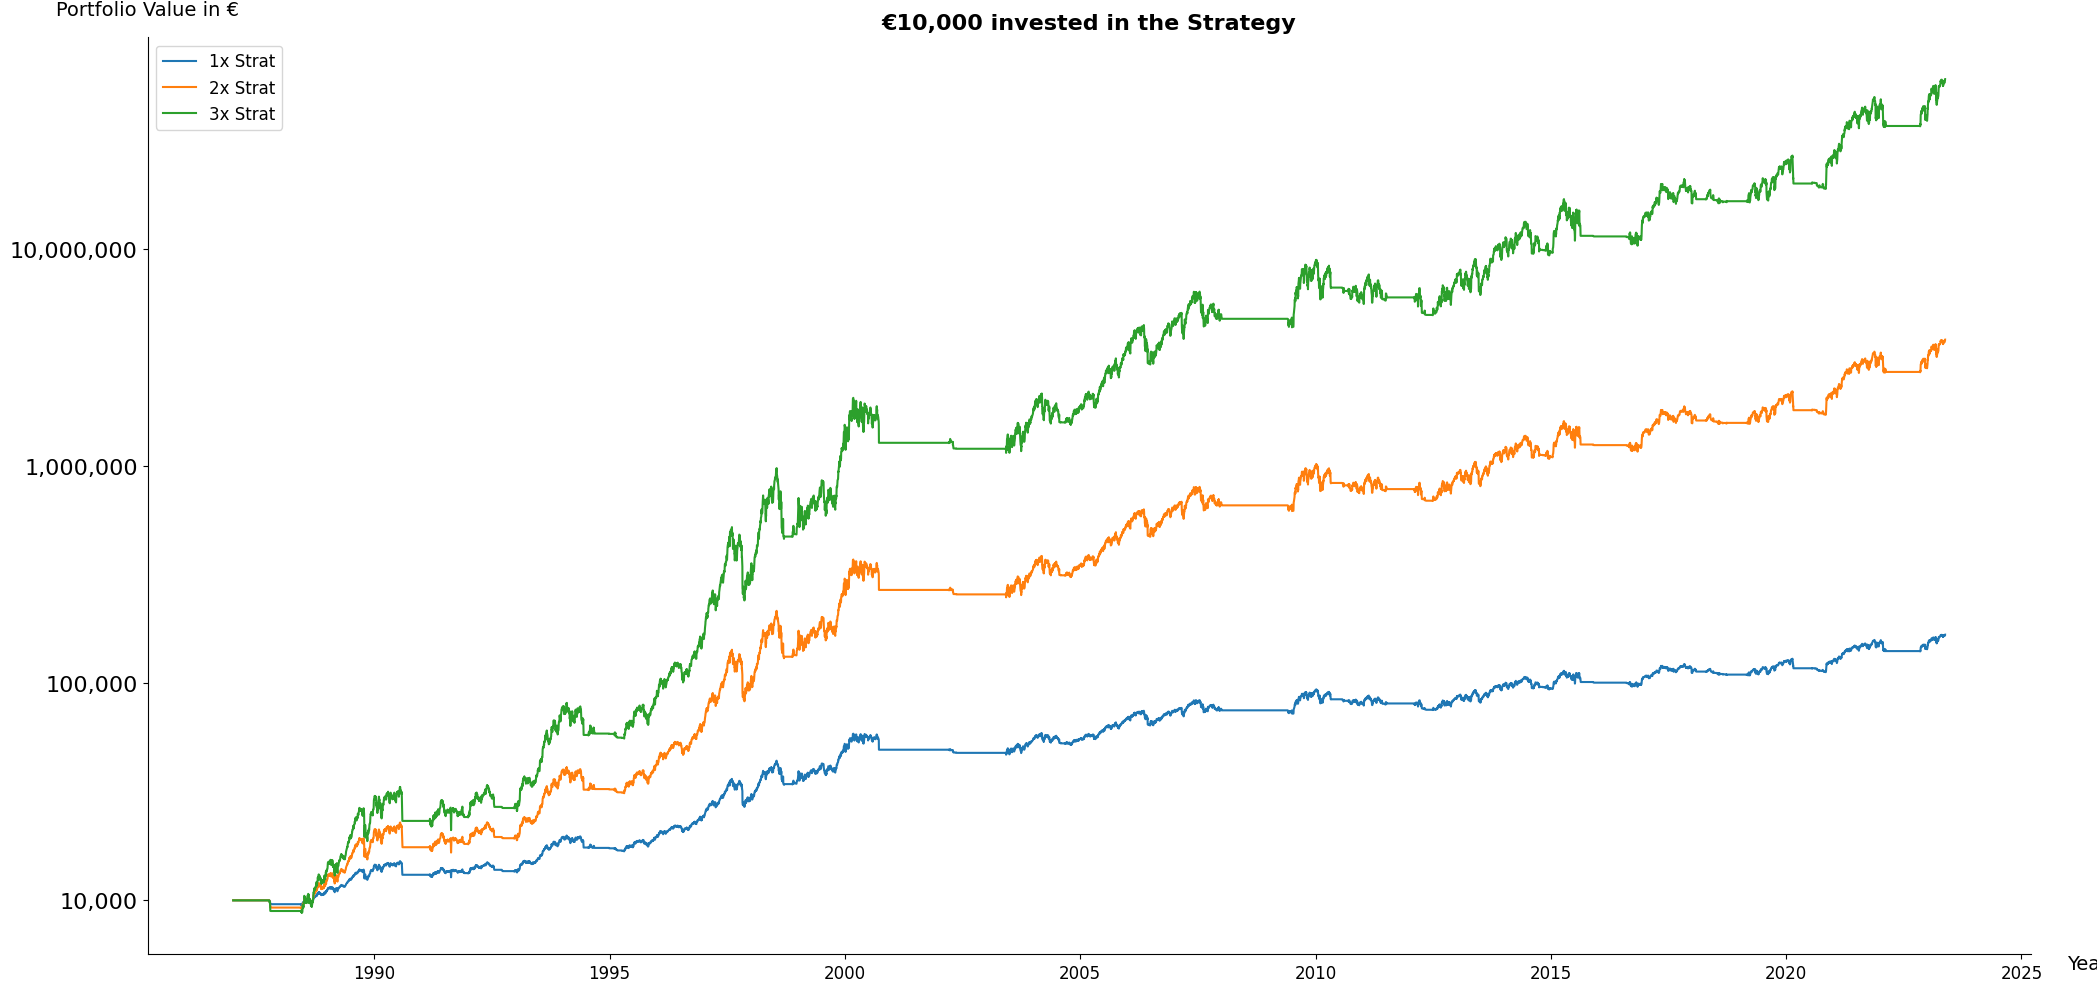

In [15]:
# Convert 'Date' column to datetime format
DF_Results['Date'] = pd.to_datetime(DF_Results['Date'])

fig, ax = plt.subplots(figsize=(21, 10))

# Plot the portfolio values
ax.plot(DF_Results['Date'], DF_Results['Portfolio Value'], label='1x Strat')
ax.plot(DF_Results['Date'], DF_Results['Portfolio Value 2x'], label='2x Strat')
ax.plot(DF_Results['Date'], DF_Results['Portfolio Value 3x'], label='3x Strat')

# Remove top and right spines
ax.spines[['top','right']].set_visible(False)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))  # Show every 5th year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Only show year
plt.xticks(rotation=0, fontsize=12)

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Set y-ticks
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0))  # Set ticks at every power of 10
ax.yaxis.set_minor_locator(NullLocator())  # Remove minor ticks
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in y_vals], fontsize=16)

# Set legend
ax.legend(fontsize=12)

# Set title
ax.set_title('€10,000 invested in the Strategy', fontsize=16, weight='bold')

# Set x and y axis labels and positions
ax.set_xlabel('Year', fontsize=14)
ax.xaxis.set_label_coords(1.03, -0)  # Position x-axis label
ax.set_ylabel('Portfolio Value in €', fontsize=14, rotation=0)
ax.yaxis.set_label_coords(-0.0, 1.02)  # Position y-axis label

plt.tight_layout()  # Automatically adjusts subplot params so that the subplot(s) fits into the figure area

plt.show()


C:\Users\Juli\AppData\Local\Temp\ipykernel_11500\480294852.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}'.format(x) for x in y_vals], fontsize=16)


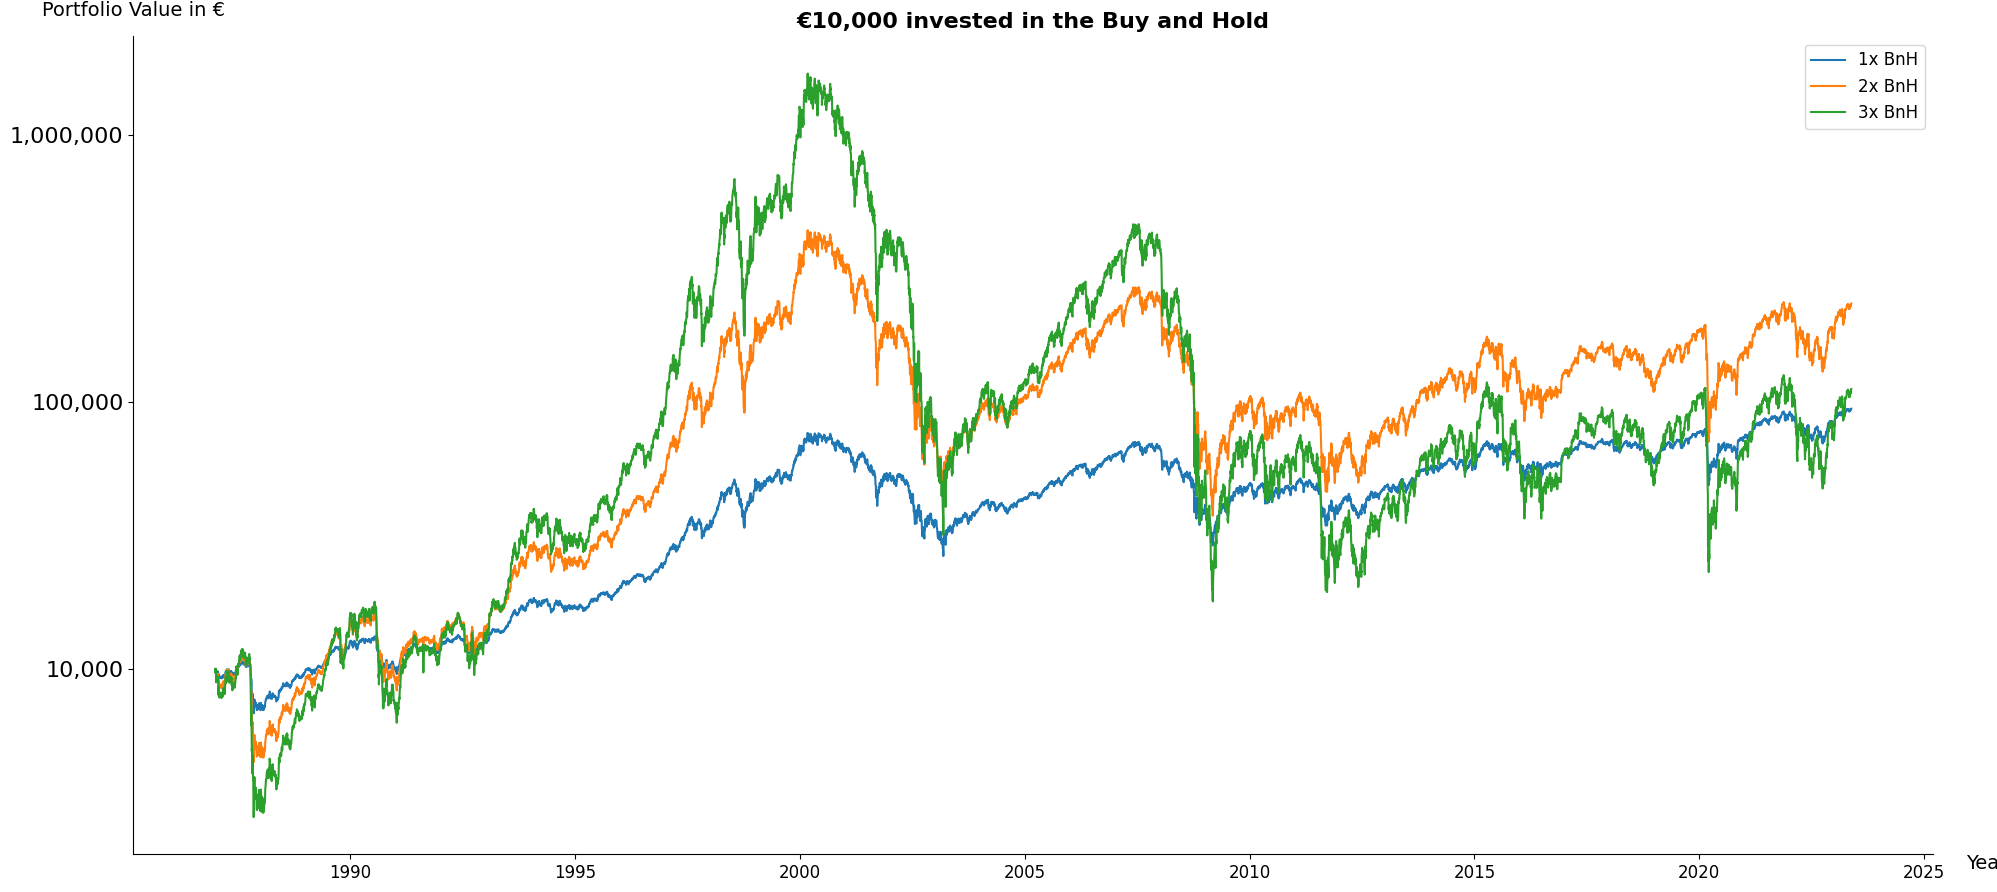

In [16]:
# Convert 'Date' column to datetime format
DF_Results['Date'] = pd.to_datetime(DF_Results['Date'])

fig, ax = plt.subplots(figsize=(20, 9))

# Plot the portfolio values
ax.plot(DF_Results['Date'], DF_Results['Simple Buy and Hold'], label='1x BnH')
ax.plot(DF_Results['Date'], DF_Results['2x Simple Buy and Hold'], label='2x BnH')
ax.plot(DF_Results['Date'], DF_Results['3x Simple Buy and Hold'], label='3x BnH')

# Remove top and right spines
ax.spines[['top','right']].set_visible(False)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))  # Show every 5th year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Only show year
plt.xticks(rotation=0, fontsize=12)

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Set y-ticks
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0))  # Set ticks at every power of 10
ax.yaxis.set_minor_locator(NullLocator())  # Remove minor ticks
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in y_vals], fontsize=16)

# Set legend
ax.legend(fontsize=12)

# Set title
ax.set_title('€10,000 invested in the Buy and Hold', fontsize=16, weight='bold')

# Set x and y axis labels and positions
ax.set_xlabel('Year', fontsize=14)
ax.xaxis.set_label_coords(1.03, 0.0)  # Position x-axis label
ax.set_ylabel('Portfolio Value in €', fontsize=14, rotation=0)
ax.yaxis.set_label_coords(-0.0, 1.02)  # Position y-axis label

plt.tight_layout()  # Automatically adjusts subplot params so that the subplot(s) fits into the figure area

plt.show()

__The backtest model is set up correctly and the backtest was conducted for all six portfolios.__

In [17]:
jupyter nbconvert --to html Backtest_model_(simplified).ipynb

SyntaxError: invalid syntax (3105119543.py, line 1)